In [1]:
import numpy as np
import cv2
import pywt
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
img = cv2.imread('./tests/macron-scaled.jpg')
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

In [ ]:
gray

In [ ]:
plt.imshow(img, cmap='gray')

In [2]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [3]:
# Return a cropped image if we find both eyes
def cropped_image(image_path):
    if image_path is None:
        return
        
    img = cv2.imread(image_path)

    if img is None:
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for x,y,w,h in faces:
        face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0,), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = face_img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)

        if len(eyes) >= 2:
            return roi_color

## Create a folder of cropped images

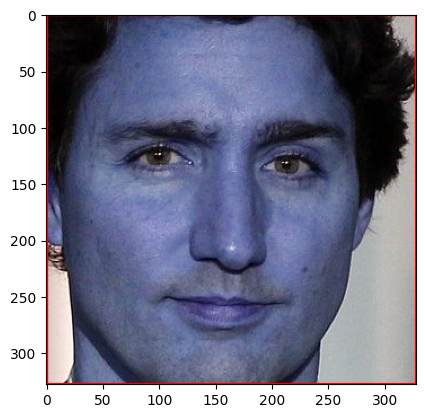

In [85]:
# test cropping
cropped_img = cropped_image('./tests/trudeau-example.jpg')
plt.imshow(cropped_img)

In [8]:
path_data = './dataset/'
path_cr = './dataset/cropped/'

In [10]:
import os

img_dirs = []
for fol in os.scandir(path_data):
    if fol.is_dir():
        img_dirs.append(fol.path)

In [11]:
img_dirs

['./dataset/Claudia Sheinbaum',
 './dataset/cropped',
 './dataset/Donald Trump',
 './dataset/Emmanuel Macron',
 './dataset/Justin Trudeau',
 './dataset/Xi Jinping']

In [ ]:
import shutil

if os.path.exists(path_cr):
    shutil.rmtree(path_cr)
os.mkdir(path_cd)

In [ ]:
from collections import defaultdict

cropped_img_dirs = []
pol_names_dict = defaultdict(list)

# Convert images into cropped versions
for fol in img_dirs:
    pol_name = fol.split('/')[-1]
    count = 1
    print('Generating images in ' + pol_name)
    
    for img_fol in os.scandir(fol):
        roi_color = cropped_image(img_fol.path)
        if roi_color is not None:
            cropped_fol = path_cr + pol_name
            if not os.path.exists(cropped_fol):
                os.makedirs(cropped_fol)
                cropped_img_dirs.append(cropped_folder)

            # Create the file
            img_name = pol_name + str(count) + '.jpg'
            img_path = cropped_fol + '/' + img_name
            count += 1
            
            cv2.imwrite(img_path, roi_color)
            pol_names_dict[pol_name].append(img_path)

## Get important features

In [5]:
def wav_transform(image, mode='haar', level=1):
    imArray = image

    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255

    # get coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    # construct
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H

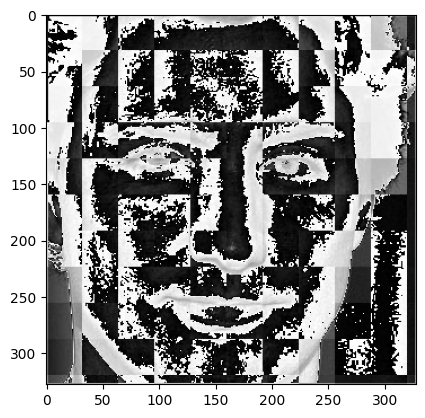

In [101]:
cropped_img = cropped_image('./tests/trudeau-example.jpg')
im_har = wav_transform(cropped_img, 'db1', 5) 
plt.imshow(im_har, cmap='gray')

## Create the dataset

In [ ]:
from collections import defaultdict
pol_names_dict = defaultdict(list)

# Copy image info into dict
for fol in img_dirs:
    pol_name = fol.split('/')[-1]

    if pol_name == 'cropped':
        continue
        
    cropped_fol = path_cr + pol_name
    
    for img_fol in os.scandir(cropped_fol):
        pol_names_dict[pol_name].append(img_fol.path)
pol_names_dict

In [18]:
label_dict = {}
count = 0

for name in pol_names_dict.keys():
    label_dict[name] = count
    count += 1

label_dict

{'Claudia Sheinbaum': 0,
 'Donald Trump': 1,
 'Emmanuel Macron': 2,
 'Justin Trudeau': 3,
 'Xi Jinping': 4}

In [29]:
X = []
y = []

for name, train_files in pol_names_dict.items():
    for image in train_files:
        img = cv2.imread(image)

        if img is None:
            continue
            
        #img_har = wav_transform(img, 'db1', 5)
        
        raw_img_scaled = cv2.resize(img, (32, 32))
        #img_har_scaled = cv2.resize(img_har, (32, 32))

        # stack the 2 images on top of one another
        #combined_img = np.vstack((raw_img_scaled.reshape(32*32*3,1), img_har_scaled.reshape(32*32,1)))
        combined_img = raw_img_scaled.reshape(32*32*3,1)
        
        X.append(combined_img)
        y.append(label_dict[name])

In [30]:
X = np.array(X).reshape(len(X), 32*32*3).astype(float)
#X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(260, 3072)

## Train the model

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8923076923076924

In [135]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       1.00      0.78      0.88         9
           2       0.86      0.95      0.90        19
           3       1.00      0.93      0.97        15
           4       0.88      0.88      0.88         8

    accuracy                           0.91        65
   macro avg       0.92      0.89      0.90        65
weighted avg       0.91      0.91      0.91        65



## Try using GridSeach with other models/parameters

In [136]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [144]:
test_model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    }
}

In [145]:
import pandas as pd

per_scores = []
best_estimators = {}

for alg, m in test_model_params.items():
    pipe = make_pipeline(StandardScaler(), m['model'])
    clf = GridSearchCV(pipe, m['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)

    per_scores.append({
        'model': alg,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

    best_estimators[alg] = clf.best_estimator_

df = pd.DataFrame(per_scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.861538,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.717949,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.856410,{'logisticregression__C': 1}


## Try models

In [146]:
best_estimators['svm'].score(X_test, y_test)

0.9230769230769231

In [147]:
best_estimators['random_forest'].score(X_test, y_test)

0.7230769230769231

In [148]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9384615384615385

In [149]:
best_clf = best_estimators['svm']

In [152]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[13,  0,  1,  0,  0],
       [ 0,  8,  1,  0,  0],
       [ 1,  1, 17,  0,  0],
       [ 0,  0,  0, 15,  0],
       [ 0,  0,  1,  0,  7]])

## Save model and dict

In [155]:
import joblib
import json

joblib.dump(best_clf, 'model.pkl')

with open('class_dict.json', 'w') as f:
    f.write(json.dumps(label_dict))